In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams

In [19]:
Site_03_full = pd.DataFrame(pd.read_csv('US03_compiled_ver1.csv'))
Site_03 = Site_03_full.dropna().reset_index(drop=True)

In [20]:
y = Site_03['depth']
UU = Site_03['U234_U238_CORR']
UTh = Site_03['Th230_U238_CORR']
UUerr = Site_03['U234_U238_CORR_Int2SE']
UTherr = Site_03['Th230_U238_CORR_Int2SE']

### Plotting raw data and 2SE 

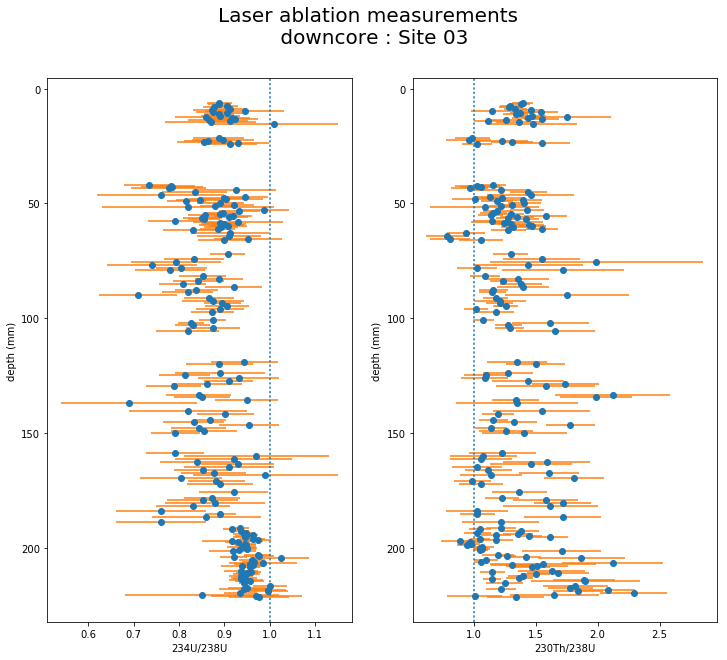

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,10))

ax1.plot(UU, y, marker='o', linestyle='')
ax1.set_ylabel('depth (mm)')
ax1.set_xlabel('234U/238U')
ax1.invert_yaxis()
ax1.axvline(x=1, linestyle=':')
ax1.errorbar(UU, y, xerr=UUerr, linestyle='')

ax2.plot(UTh, y, marker='o', linestyle='')
ax2.set_ylabel('depth (mm)')
ax2.set_xlabel('230Th/238U')
ax2.invert_yaxis()
ax2.axvline(x=1, linestyle=':')
ax2.errorbar(UTh, y, xerr=UTherr, linestyle='')

plt.suptitle('Laser ablation measurements \n downcore : Site 03', fontsize=20)

plt.show()

### Savitzky-Golay filter: 

uses least squares to regress a small window of your data onto a polynomial, then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward by one data point and the process repeats. This continues until every point has been optimally adjusted relative to its neighbors.

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

http://scipy.github.io/devdocs/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter

from docs:
scipy.signal.savgol_filter(data, window len, polynomial order...)

    -Increasing the window size decreases the amplitude of osillations in the filter
    -Increasing the polynomial order -> hitting more of the datapoints
    -Polynomial order must be less than the window size, range from 1-6

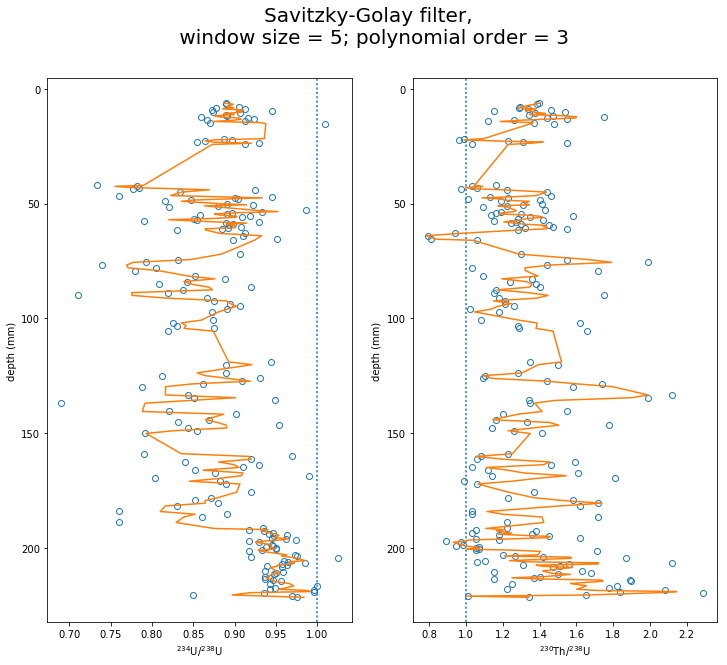

In [24]:
#window size = 5; polynomial order = 3
from scipy.signal import savgol_filter

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,10))

xhat_UU = savgol_filter(UU, 5, 3) 
xhat_UTh = savgol_filter(UTh, 5, 3) 

ax1.plot(UU, y, marker='o', linestyle='', fillstyle='none')
ax1.set_ylabel('depth (mm)')
ax1.set_xlabel('$^{234}$U/$^{238}$U')
ax1.invert_yaxis()
ax1.axvline(x=1, linestyle=':')
ax1.plot(xhat_UU, y)

ax2.plot(UTh, y, marker='o', linestyle='', fillstyle='none')
ax2.set_ylabel('depth (mm)')
ax2.set_xlabel('$^{230}$Th/$^{238}$U')
ax2.invert_yaxis()
ax2.axvline(x=1, linestyle=':')
ax2.plot(xhat_UTh, y)

plt.suptitle('Savitzky-Golay filter, \n window size = 5; polynomial order = 3', fontsize=20)
plt.show()

### Using the sum of absolute differences to select a window length:

    -Test a range of window sizes from 5 to 53
    -Calculate the sum of absolute difference for each window size 
    -Plot for each dataset (234U/238U and 230Th/238U)

In [25]:
#define window lengths to test
a = np.arange(5, 55) #starting array
WindowSizes = (a[a%2==1]) #make all the numbers odd        
WindowSizes

array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37,
       39, 41, 43, 45, 47, 49, 51, 53])

In [26]:
def SAD(data, smoothed):
    return sum(abs(data-smoothed))

def residuals(observation, prediction):
    return observation - prediction

hold = pd.DataFrame(columns=['Window-len', 'obs_UU', 'pred_UU', 'UU_resid' ,'SAD_UU',
                             'obs_UTh', 'pred_UTh', 'UTh_resid' ,'SAD_UTh'])
#I might want to use these later...

for i in WindowSizes:
    smooth_UU = savgol_filter(UU, i, 3) 
    smooth_UTh = savgol_filter(UTh, i, 3)
    
    temp = pd.DataFrame()
    
    temp['Window-len'] = i
    temp['obs_UU'] = UU
    temp['pred_UU'] = smooth_UU
    temp['UU_resid'] = residuals(UU, smooth_UU)
    temp['SAD_UU'] = SAD(UU, smooth_UU)
    temp['obs_UTh'] = UTh
    temp['pred_UTh'] = smooth_UTh
    temp['UTha_resid'] = residuals(UTh, smooth_UTh)
    temp['SAD_UTh'] = SAD(UTh, smooth_UTh)
    
    hold = hold.append(pd.DataFrame(data=temp), sort=False)

In [30]:
len(UU)

177

In [31]:
hold['Window-len']=np.repeat(WindowSizes,177)
#hold

In [32]:
WS = [str(n) for n in WindowSizes] #make the column headers strings, in order to call by index 
SG_windowtest = pd.DataFrame(index=['SAD_UU','SAD_UTh'], columns=[WS])
y1 = SG_windowtest.loc['SAD_UU'] =hold['SAD_UU'].unique()
y2 = SG_windowtest.loc['SAD_UTh'] =hold['SAD_UTh'].unique()
#SG_windowtest

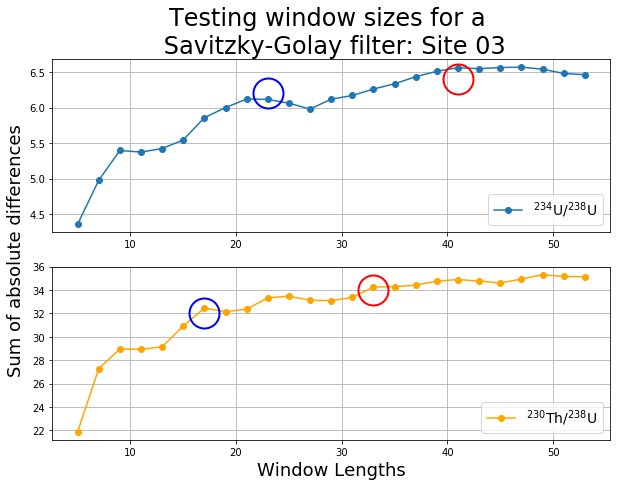

In [35]:
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(111) #to share the axis labels
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

#plotting the data
ax1.plot(WindowSizes, y1, marker='o', label='$^{234}$U/$^{238}$U')
ax1.grid()
ax1.legend(loc='lower right', fontsize=14)

ax2.plot(WindowSizes, y2, marker='o', color='orange', label='$^{230}$Th/$^{238}$U')
ax2.grid()
ax2.legend(loc='lower right', fontsize=14)

#annotating the plot
circle_rad = 15
ax1.plot(23, 6.2, 'o', ms=circle_rad * 2, mec='b', mfc='none', mew=2)
ax1.plot(41, 6.4, 'o', ms=circle_rad * 2, mec='r', mfc='none', mew=2)
ax2.plot(17, 32, 'o', ms=circle_rad * 2, mec='b', mfc='none', mew=2)
ax2.plot(33, 34, 'o' ,ms=circle_rad * 2, mec='r', mfc='none', mew=2)

ax.set_xlabel('Window Lengths', fontsize=18)
ax.set_ylabel('Sum of absolute differences', fontsize=18)
ax.set_title('Testing window sizes for a \n Savitzky-Golay filter: Site 03', fontsize=24)

plt.show()

#### for the U/U : test windows 23 and 41
#### for the U/Th : test windows 17 and 33

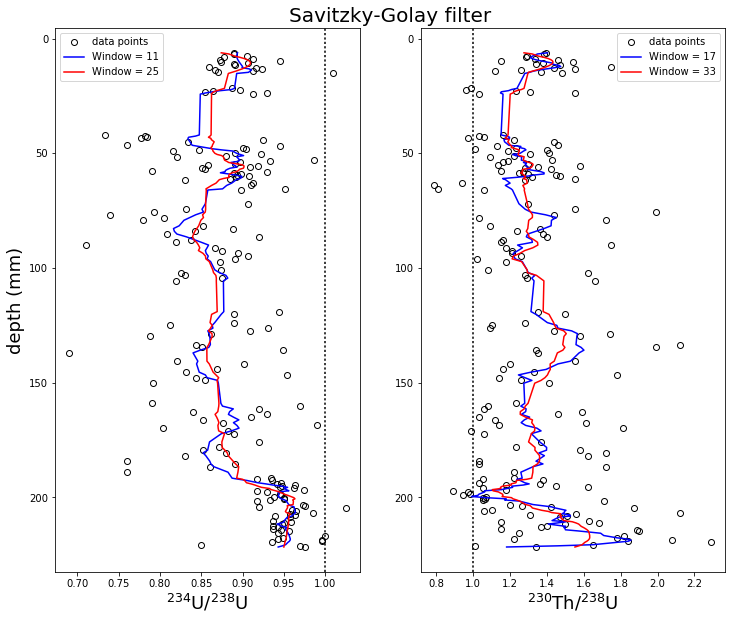

In [36]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111) #to share the axis labels
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

win23U = savgol_filter(UU, 23, 3)
win41U = savgol_filter(UU, 41, 3)
win17T = savgol_filter(UTh, 17, 3)
win33T = savgol_filter(UTh, 33, 3)

ax1.plot(UU, y, 'ko', linestyle='', fillstyle='none', label='data points')
ax1.set_ylabel('depth (mm)', fontsize=18)
ax1.set_xlabel('$^{234}$U/$^{238}$U', fontsize=18)
ax1.invert_yaxis()
ax1.axvline(x=1, linestyle=':', color='k')
ax1.plot(win23U, y, color='b', label='Window = 11')
ax1.plot(win41U, y, color='r', label='Window = 25')
ax1.legend(loc='upper left')

ax2.plot(UTh, y, 'ko', linestyle='', fillstyle='none', label='data points')
ax2.set_xlabel('$^{230}$Th/$^{238}$U', fontsize=18)
ax2.invert_yaxis()
ax2.axvline(x=1, linestyle=':', color='k')
ax2.plot(win17T, y, color='b', label='Window = 17')
ax2.plot(win33T, y, color='r', label='Window = 33')
ax2.legend(loc='upper right')

ax.set_title('Savitzky-Golay filter', fontsize=20)
plt.show()

In [37]:
#don't keep typing out the latex
U_label = '$^{234}$U/$^{238}$U'
Th_label = '$^{230}$Th/$^{238}$U'

### Residuals of the four models:

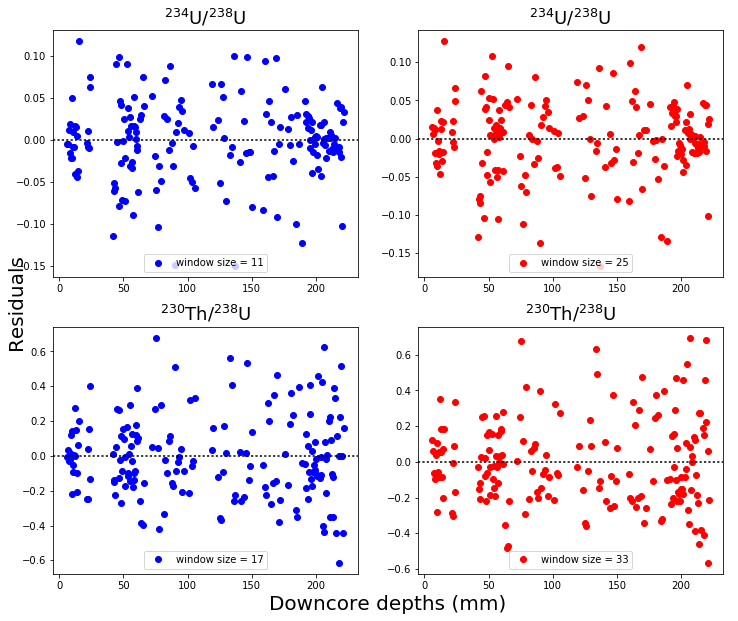

In [38]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111) #to share the axis labels
ax1 = fig.add_subplot(221) #Residual plot for U/U window = 11
ax2 = fig.add_subplot(222) #Residual plot for U/U window = 25
ax3 = fig.add_subplot(223) #Residual plot for U/Th window = 17
ax4 = fig.add_subplot(224) #Residual plot for U/Th window = 33

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

#getting the residuals 
r_win23U = residuals(UU,win23U)
r_win41U = residuals(UU,win41U)
r_win17T = residuals(UTh,win17T)
r_win33T = residuals(UTh,win33T)

ax1.plot(y, r_win23U, marker='o', linestyle='', color='b', label='window size = 11')
ax1.axhline(y=0, linestyle=':', color='k')
ax1.set_title(U_label, fontsize=18)
ax1.legend(loc='lower center')

ax2.plot(y, r_win41U, marker='o', linestyle='', color='r', label='window size = 25')
ax2.axhline(y=0, linestyle=':', color='k')
ax2.set_title(U_label, fontsize=18)
ax2.legend(loc='lower center')

ax3.plot(y, r_win17T, marker='o', linestyle='', color='b', label='window size = 17')
ax3.axhline(y=0, linestyle=':', color='k')
ax3.set_title(Th_label, fontsize=18)
ax3.legend(loc='lower center')

ax4.plot(y, r_win33T, marker='o', linestyle='', color='r', label='window size = 33')
ax4.axhline(y=0, linestyle=':', color='k')
ax4.set_title(Th_label, fontsize=18)
ax4.legend(loc='lower center')

ax.set_ylabel('Residuals', fontsize=20)
ax.set_xlabel('Downcore depths (mm)', fontsize=20)

plt.show()

### Printing the depths vs. ratios for the smoothed dataset

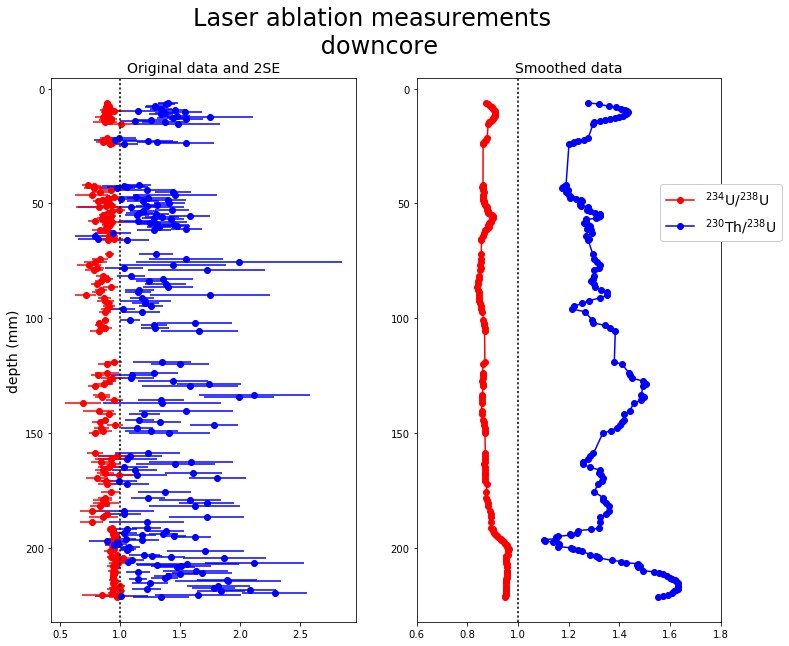

In [40]:
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(121) #to share the axis labels
ax2 = fig.add_subplot(122)

ax1.plot(UU, y, marker='o',color='r',label=U_label, linestyle='')
ax1.plot(UTh, y, marker='o',color='b', label=Th_label, linestyle='')
ax1.set_ylabel('depth (mm)', fontsize=14)
ax1.invert_yaxis()
ax1.axvline(x=1, linestyle=':', color='k')
ax1.errorbar(UTh, y, xerr=UTherr, linestyle='', color='b')
ax1.errorbar(UU, y, xerr=UUerr, linestyle='', color='r')
ax1.set_title('Original data and 2SE', fontsize=14)

ax2.plot(win41U, y, marker='o', color='r', label=U_label)
ax2.plot(win33T, y, marker='o', color='b', label=Th_label)
ax2.invert_yaxis()
ax2.axvline(x=1, linestyle=':', color='k')
ax2.legend(loc=(.8,0.7), fontsize=14, framealpha=1)
ax2.set_title('Smoothed data', fontsize=14)
ax2.set_xlim(0.6,1.8)

plt.suptitle('Laser ablation measurements \n downcore', fontsize=24)
plt.savefig('Site03_smoothedAndOriginal.png', layout='tight')
plt.show()

In [41]:
win33T = pd.Series(win33T)
win41U = pd.Series(win41U)
y = pd.Series(y.reset_index(drop=True))
UTherr = pd.Series(UTherr.reset_index(drop=True))
UUerr = pd.Series(UUerr.reset_index(drop=True))

In [42]:
objs = [y, win41U, UUerr, win33T, UTherr]
names = ['depth','U_U','U2SE','U_Th','Th2SE']
Site03_smooth = pd.concat(objs, axis=1)
Site03_smooth.set_axis(names, axis=1, inplace=True)
Site03_smooth.to_excel("Site03_SG.xls")